# Homework 2

## PCA and LDA comparison

### 1. Import the data(MINST)

In [1]:
#1. Import the data (MNIST) as always 
import numpy as np
import pandas as pd

# Load data into memory
data = pd.read_csv('data.csv')
data_np = np.array(data)
print(data.shape)


(42000, 785)


### 2. Split the data: Convert data into a matrix

### 3. Choose a number of digits and extract from X and Y the sub-dataset, and then re-call X and Y those datasets Find the corresponding indeces

In [2]:



d = 784
N = 42_000  # datapoints

X = data_np[:N, 1:].T         
Y = data_np[:N, 0]       # 1' colonna       


I1 = (Y==0)
I2 = (Y==6)
I3 = (Y==9)

# Split X into X1, X2, X3
X1 = X[:, I1]
X2 = X[:, I2]
X3 = X[:, I3]

# Spit Y into Y1, Y2, Y3
Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]

# Concatenate the data
X = np.concatenate((X1, X2, X3), axis=1)
Y = np.concatenate((Y1, Y2, Y3))
print("new X shape: ", X.shape, "\nnew Y shape: ", Y.shape)

new X shape:  (784, 12457) 
new Y shape:  (12457,)


### 4. Set Ntrain < N and randomly sample a training set with Ntrain datapoints from X (and the corresponding Y ).  Call them Xtrain and Ytrain. Everything else is the test set. Call it Xtest and Ytest.

In [3]:
def split_data(X, Y, Ntrain):
    d, N = X.shape       # 784, 42.000

    idx = np.arange(N)    
    np.random.shuffle(idx)     

    train_idx = idx[:Ntrain]    
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:,test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Xtest), (Ytrain, Ytest)

(Xtrain, Xtest), (Ytrain, Ytest) = split_data(X, Y, 3_000)
print ("Xtrain and Xtest shape: ",Xtrain.shape, Xtest.shape)
print ("Ytrain and Ytest shape: ",Ytrain.shape, Ytest.shape)

Xtrain and Xtest shape:  (784, 3000) (784, 9457)
Ytrain and Ytest shape:  (3000,) (9457,)


### Computing centroids

In [4]:
# Compute the centroid of each class:
def compute_centroid(X, Y, k):
    return np.mean(X[:, Y==k], axis=1)

def compute_centroid_class(X, Y):
    centroids=[]
    digits = [0,6,9]

    for i in range(len(digits)):
        centroids.append(compute_centroid(X, Y, digits[i]))
        
    return np.array(centroids)

### 5. Implement the algorithms computing the PCA with Xtrain

In [5]:
def impl_PCA(X, Y, k):
    
    # Compute the centered version of X as:    Xc = X − c(X)    
    cx = np.array([np.mean(col) for col in X])
    Xc = (X.T - cx).T
    
    c_i = compute_centroid_class(Xc, Y)      # DEVE ESSERE SU X_CENTRATO!!
    
    U, s, VT = np.linalg.svd(Xc, full_matrices=False)
           
    U_k = U[:, :k]
    Z_k = U_k.T @ Xc            # Z_k: projected space (colomns of Z_k are the pricipal components of X)
    
    Z_c = U_k.T @ c_i.T     # proietto i centroidi sul projected space Z

    return Z_k, U_k.T, Z_c

Z_PCA_train, Ut, cZ_PCA_train = impl_PCA(Xtrain, Ytrain, 3)

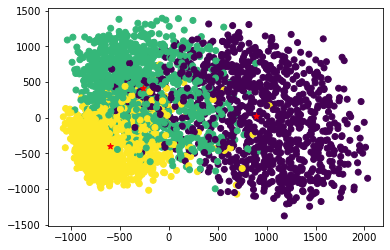

In [6]:
import matplotlib.pyplot as plt
# Plot clusters of PCA_train:
plt.scatter(Z_PCA_train[0, :], Z_PCA_train[1, :], c=Ytrain)

digits = [0,6,9]
for i in range(len(digits)):
    cZ_i = cZ_PCA_train[:,i]
    plt.scatter(cZ_i[0], cZ_i[1], c="red", marker="*")

plt.show()

### 5. Implement the algorithms computing the LDA with Xtrain

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse.linalg as linalg

def X_kc(datapoint):
    centroidK = np.mean(datapoint, axis=1)
    centroidK = np.reshape(centroidK, (len(centroidK), 1))

    X_kc = datapoint - centroidK
    return centroidK, X_kc

def impl_LDA(X, Y, k):

    # Split X into X1, X2, X3
    x1 = X[:, (Y==0)]
    x2 = X[:, (Y==6)]
    x3 = X[:, (Y==9)]

    # Within-Cluster Scatter Matrix
    C1, X1c = X_kc(x1)
    C2, X2c = X_kc(x2)
    C3, X3c = X_kc(x3)
    
    c_i = np.concatenate((C1, C2, C3), axis=1).T

    Xw = np.concatenate((X1c, X2c, X3c), axis=1)
    Sw = Xw @ Xw.T

    # Between Clusters Scattering Matrix:
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)             
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)

    C, _ = X_kc(X)  

    Xbar = np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)

    Xbar_c = Xbar - C.reshape((d,1))            

    Sb = Xbar_c @ Xbar_c.T

    try:
        L = np.linalg.cholesky(Sw)
    except:
        # Make the Sw positive for sure:
        identity = np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw + 1e-6 * identity)

    _, eigenvectors = linalg.eigs(np.linalg.inv(L) @ Sb @ L, k)
    W = np.real(eigenvectors) 
    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X

    # centroidi proiettati
    cZ = Q.T @ c_i.T

    return Z, Q.T, cZ

Z_LDA_train, Qt, cZ_LDA_train = impl_LDA(Xtrain, Ytrain, 2)

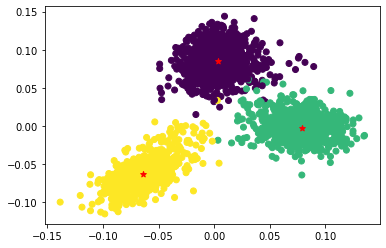

In [14]:
# Visualize the clusters and centroid: 
plt.scatter(Z_LDA_train[0, :], Z_LDA_train[1, :], c=Ytrain)

digits = [0,6,9]
for i in range(len(digits)):
    cZ_i = cZ_LDA_train[:,i]
    plt.scatter(cZ_i[0], cZ_i[1], c="red", marker="*")
    
plt.show()

### 6. For both the algorithms, compute for each cluster the average distance from the centroid.

In [15]:
def dist_intra_cluster(Z, centroids, Y):  
    intra_dists = []
    sum=0
    for i in range(len(digits)):
        cluster_points = Z[:, Y==int(digits[i])]
        intra_dists.append(np.mean(np.array([np.linalg.norm(x - centroids[:,i]) for x in cluster_points.T])))
        sum+=intra_dists[i]
    for i in range(len(intra_dists)):
        intra_dists[i]=intra_dists[i]/sum
    return intra_dists

In [16]:
# compute for each cluster the average distance from the centroid on the TRAIN set
distPCA = dist_intra_cluster(Z_PCA_train, cZ_PCA_train, Ytrain)
distLDA = dist_intra_cluster(Z_LDA_train, cZ_LDA_train, Ytrain)
print("average distance intra cluster of TRAIN set")
print("pca: ", distPCA)
print("lda: ", distLDA)

average distance intra cluster of TRAIN set
pca:  [0.4207602843343774, 0.3472709226497119, 0.23196879301591075]
lda:  [0.35342071104856915, 0.32802660796660466, 0.31855268098482614]


### 6. For both the algorithms, compute for each cluster the average distance from the centroid on the test set.

In [81]:
# Compute for each cluster the average distance from the centroid on the TEST set

# PCA lavora sempre con dataset centrati !!
X_test_centered = np.array([np.mean(col) for col in Xtest])
X_test_centered = (Xtest.T - X_test_centered).T

Z_PCA_test = (Ut @ X_test_centered)
Z_LDA_test = (Qt @ Xtest)

distPCA = dist_intra_cluster(Z_PCA_test, cZ_PCA_train, Ytest)
distLDA = dist_intra_cluster(Z_LDA_test, cZ_LDA_train, Ytest)
print("average distance intra cluster of TEST set")
print("pca: ", distPCA)
print("lda: ", distLDA)

average distance intra cluster of TEST set
pca:  [0.42022637971588195, 0.34334499261186013, 0.23642862767225795]
lda:  [0.3111923626302856, 0.3141737736560672, 0.3746338637136472]


### 7. Define a classification algorithm in this way: given a new observation x, compute the distance between x and each cluster centroid. Assign x to the class corresponding the the closer centroid. Compute the accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA;


In [82]:
def classifier(point, centroids):
    n = 0
    digits = [0,6,9]

    for c in range(len(digits)):
        d = np.linalg.norm(centroids[:, c] - point, 2)
        if c==0:
            d_min=d
        if d <= d_min:
            d_min = d
            n = digits[c]
    return n

def accuracy_score(point_set, ground_truth, centroids):
    correct = 0
    for i in range(point_set.shape[1]):
        prediction = classifier(point_set[:, i], centroids)
        if(prediction == ground_truth[i]):
            correct += 1
    print("correct: ", correct, "tot: ", ground_truth.shape[0])
    return (correct/ground_truth.shape[0])*100

In [83]:
pca_accuracy = accuracy_score(Z_PCA_train, Ytrain, cZ_PCA_train)
lda_accuracy = accuracy_score(Z_LDA_train, Ytrain, cZ_LDA_train)

print("Accuracy PCA train: {} %".format(pca_accuracy))
print("Accuracy LDA train: {} %".format(lda_accuracy))

correct:  2800 tot:  3000
correct:  2983 tot:  3000
Accuracy PCA train: 93.33333333333333 %
Accuracy LDA train: 99.43333333333332 %


In [84]:
X_test_centered = np.array([np.mean(col) for col in Xtest])
X_test_centered = (Xtest.T - X_test_centered).T

pca_accuracy = accuracy_score((Ut @ X_test_centered), Ytest, cZ_PCA_train)
lda_accuracy = accuracy_score((Qt @ Xtest), Ytest, cZ_LDA_train)

print("Accuracy PCA test: {} %".format(pca_accuracy))
print("Accuracy LDA test: {} %".format(lda_accuracy))

correct:  8804 tot:  9457
correct:  9162 tot:  9457
Accuracy PCA test: 93.09506185894047 %
Accuracy LDA test: 96.88061753198689 %


### Printing accuracy for different values of k


correct:  8804 tot:  9457
correct:  9162 tot:  9457
correct:  8927 tot:  9457
correct:  9146 tot:  9457
correct:  8969 tot:  9457
correct:  9149 tot:  9457
correct:  8973 tot:  9457
correct:  9147 tot:  9457
correct:  8977 tot:  9457
correct:  9148 tot:  9457
correct:  8994 tot:  9457
correct:  9143 tot:  9457
correct:  9003 tot:  9457
correct:  9139 tot:  9457
correct:  9006 tot:  9457
correct:  9138 tot:  9457
correct:  9014 tot:  9457
correct:  9139 tot:  9457
correct:  9014 tot:  9457
correct:  9139 tot:  9457
correct:  9018 tot:  9457
correct:  9138 tot:  9457
correct:  9022 tot:  9457
correct:  9143 tot:  9457
correct:  9022 tot:  9457
correct:  9139 tot:  9457
correct:  9023 tot:  9457
correct:  9141 tot:  9457
correct:  9026 tot:  9457
correct:  9147 tot:  9457
correct:  9027 tot:  9457
correct:  9140 tot:  9457
correct:  9023 tot:  9457
correct:  9146 tot:  9457
correct:  9023 tot:  9457
correct:  9141 tot:  9457
correct:  9025 tot:  9457
correct:  9139 tot:  9457
correct:  90

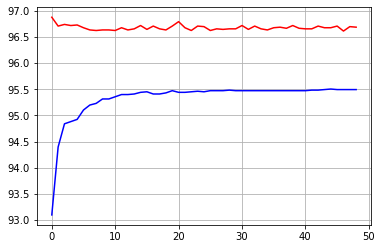

In [86]:
LDA=[]
PCA=[]
for i in range(2,51):
    Z_PCA_train, Ut, cZ_PCA_train = impl_PCA(Xtrain, Ytrain, i+1)
    Z_LDA_train, Qt, cZ_LDA_train = impl_LDA(Xtrain, Ytrain, i)
    X_test_centered = np.array([np.mean(col) for col in Xtest])
    X_test_centered = (Xtest.T - X_test_centered).T
    pca_accuracy = accuracy_score((Ut @ X_test_centered), Ytest, cZ_PCA_train)
    lda_accuracy = accuracy_score((Qt @ Xtest), Ytest, cZ_LDA_train)
    PCA.append(pca_accuracy)
    LDA.append(lda_accuracy)
plt.plot(PCA,c='blue')
plt.plot(LDA,c='red')
plt.grid()
plt.show()

### Code to implement the experiment again

In [68]:
X = data_np[:N, 1:].T         
Y = data_np[:N, 0]       # 1' colonna       


I1 = (Y==1)
I2 = (Y==3)
I3 = (Y==5)

# Split X into X1, X2, X3
X1 = X[:, I1]
X2 = X[:, I2]
X3 = X[:, I3]

# Spit Y into Y1, Y2, Y3
Y1 = Y[I1]
Y2 = Y[I2]
Y3 = Y[I3]

# Concatenate the data
X = np.concatenate((X1, X2, X3), axis=1)
Y = np.concatenate((Y1, Y2, Y3))
print("new X shape: ", X.shape, "\nnew Y shape: ", Y.shape)

def split_data(X, Y, Ntrain):
    d, N = X.shape       # 784, 42.000

    idx = np.arange(N)    
    np.random.shuffle(idx)     

    train_idx = idx[:Ntrain]    
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[:,test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Xtest), (Ytrain, Ytest)

(Xtrain, Xtest), (Ytrain, Ytest) = split_data(X, Y, 3_000)

def classifier2(point, centroids):
    d_min = 1000
    n = 0
    digits = [1,3,5]

    for c in range(len(digits)):
        d = np.linalg.norm(centroids[:, c] - point, 2)
        if c==0:
            d_min=d
        if d <= d_min:
            d_min = d
            n = digits[c]
    return n

def accuracy_score2(point_set, ground_truth, centroids):
    correct = 0
    for i in range(point_set.shape[1]):
        prediction = classifier2(point_set[:, i], centroids)
        if(prediction == ground_truth[i]):
            correct += 1
    print("correct: ", correct, "tot: ", ground_truth.shape[0])
    return (correct/ground_truth.shape[0])*100

def compute_centroid2(X, Y, k):
    return np.mean(X[:, Y==k], axis=1)

def compute_centroid_class2(X, Y):
    centroids=[]
    digits = [1,3,5]

    for i in range(len(digits)):
        centroids.append(compute_centroid2(X, Y, digits[i]))
        
    return np.array(centroids)

def impl_PCA2(X, Y, k):
    
    # Compute the centered version of X as:    Xc = X − c(X)    
    cx = np.array([np.mean(col) for col in X])
    Xc = (X.T - cx).T
    
    c_i = compute_centroid_class2(Xc, Y)      # DEVE ESSERE SU X_CENTRATO!!
    
    U, s, VT = np.linalg.svd(Xc, full_matrices=False)
           
    U_k = U[:, :k]
    Z_k = U_k.T @ Xc            # Z_k: projected space (colomns of Z_k are the pricipal components of X)
    
    Z_c = U_k.T @ c_i.T     # proietto i centroidi sul projected space Z

    return Z_k, U_k.T, Z_c

def impl_LDA2(X, Y, k):

    # Split X into X1, X2, X3
    x1 = X[:, (Y==1)]
    x2 = X[:, (Y==3)]
    x3 = X[:, (Y==5)]

    # Within-Cluster Scatter Matrix
    C1, X1c = X_kc(x1)
    C2, X2c = X_kc(x2)
    C3, X3c = X_kc(x3)
    
    c_i = np.concatenate((C1, C2, C3), axis=1).T

    Xw = np.concatenate((X1c, X2c, X3c), axis=1)
    Sw = Xw @ Xw.T

    # Between Clusters Scattering Matrix:
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)             
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)

    C, _ = X_kc(X)  

    Xbar = np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)

    Xbar_c = Xbar - C.reshape((d,1))            

    Sb = Xbar_c @ Xbar_c.T

    try:
        L = np.linalg.cholesky(Sw)
    except:
        # Make the Sw positive for sure:
        identity = np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw + 1e-6 * identity)

    _, eigenvectors = linalg.eigs(np.linalg.inv(L) @ Sb @ L, k)
    W = np.real(eigenvectors) 
    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X

    # centroidi proiettati
    cZ = Q.T @ c_i.T

    return Z, Q.T, cZ

Z_PCA_train, Ut, cZ_PCA_train = impl_PCA2(Xtrain, Ytrain, 20)

Z_LDA_train, Qt, cZ_LDA_train = impl_LDA2(Xtrain, Ytrain, 19)

new X shape:  (784, 12830) 
new Y shape:  (12830,)


### 8. Repeat this experiment for different values of k and different digits.

In [69]:
pca_accuracy = accuracy_score2(Z_PCA_train, Ytrain, cZ_PCA_train)
lda_accuracy = accuracy_score2(Z_LDA_train, Ytrain, cZ_LDA_train)

print("Accuracy PCA train: {} %".format(pca_accuracy))
print("Accuracy LDA train: {} %".format(lda_accuracy))

X_test_centered = np.array([np.mean(col) for col in Xtest])
X_test_centered = (Xtest.T - X_test_centered).T

pca_accuracy = accuracy_score2((Ut @ X_test_centered), Ytest, cZ_PCA_train)
lda_accuracy = accuracy_score2((Qt @ Xtest), Ytest, cZ_LDA_train)

print("Accuracy PCA test: {} %".format(pca_accuracy))
print("Accuracy LDA test: {} %".format(lda_accuracy))

correct:  2632 tot:  3000
correct:  2945 tot:  3000
Accuracy PCA train: 87.73333333333333 %
Accuracy LDA train: 98.16666666666667 %
correct:  8592 tot:  9830
correct:  9173 tot:  9830
Accuracy PCA test: 87.4059003051882 %
Accuracy LDA test: 93.31637843336725 %


## Visualizing dyad

### Consider an image from skimage.data. For simplicity, say that X ∈ R m×n is the matrix representing that image. You are asked to visualize the dyad of the SVD Decomposition of X and the result of compressing the image via SVD
### Load the image into memory and compute its SVD

(660, 550)
(660, 550) (550,) (550, 550)


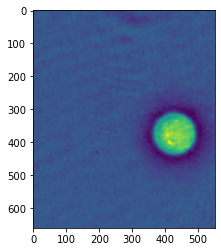

In [42]:
import numpy as np
import matplotlib.pyplot as plt
#Visualizing dyad
from skimage import data
original = data.cell()
print(original.shape)
U, s, VT = np.linalg.svd(original, full_matrices=False)
print(U.shape,s.shape,VT.shape)
plt.imshow(original)
plt.show()

### Visualize some of the dyad of this decomposition

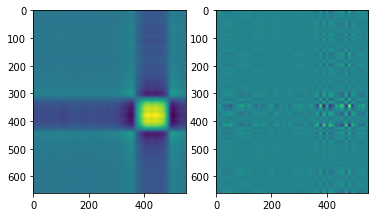

<function matplotlib.pyplot.show(close=None, block=None)>

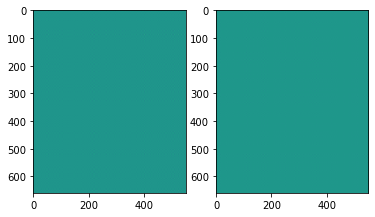

In [43]:
def dyad(i,U,s,VT):
    A_ri=np.zeros((660,550))
    u_i=U[:,i]
    s_i=s[i]
    v_i=VT[i,:]
    u_i=u_i.reshape(660,1)
    s_i=s_i.reshape(1,1)
    v_i=v_i.reshape(1,550)
    A_ri=(s_i*(u_i@v_i))
    return A_ri


A_r1=dyad(1,U,s,VT)
A_r2=dyad(10,U,s,VT)
A_r3=dyad(100,U,s,VT)
A_r4=dyad(549,U,s,VT)

plt.subplot(1,2,1)
plt.imshow(A_r1)
plt.subplot(1,2,2)
plt.imshow(A_r2)
plt.show()

plt.subplot(1,2,1)
plt.imshow(A_r3)
plt.subplot(1,2,2)
plt.imshow(A_r4)
plt.show

### Plot the singular values of X

<function matplotlib.pyplot.show(close=None, block=None)>

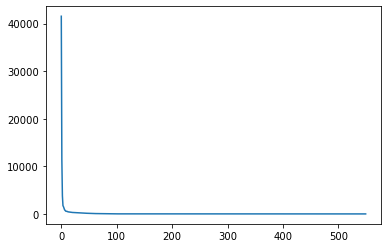

In [44]:
plt.plot(s)
plt.show

### Visualize the k-rank approximation of X for different values of k.

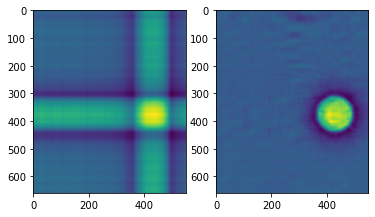

<function matplotlib.pyplot.show(close=None, block=None)>

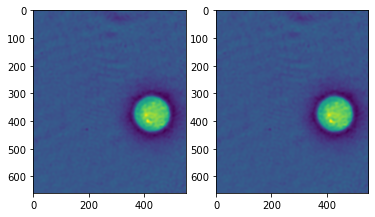

In [45]:
def k_rank_approximation(i,U,s,VT):
    A_ri=np.zeros((660,550))
    for c in range(i):
        u_i=U[:,c]
        s_i=s[c]
        v_i=VT[c,:]
        u_i=u_i.reshape(660,1)
        s_i=s_i.reshape(1,1)
        v_i=v_i.reshape(1,550)
        A_ri=A_ri+(s_i*(u_i@v_i))
    return A_ri

# svX=[]
# A_star=np.zeros((660,550))
# for i in range(399):
#     u_i,s_i,v_i=dyad(i,U,s,VT)
#     A_ri=s_i*u_i@v_i
#     A_star=A_star+A_ri
#     svX.append(s_i)

# print(svX)
A_r1=k_rank_approximation(1,U,s,VT)
A_r2=k_rank_approximation(10,U,s,VT)
A_r3=k_rank_approximation(100,U,s,VT)
A_r4=k_rank_approximation(549,U,s,VT)

# # print(u_1.shape,s_1.shape,v_1.shape)
# A_r1=s_1*(u_1@v_1)
# A_r2=s_2*(u_2@v_2)
# A_r3=s_3*(u_3@v_3)
# A_r4=s_4*(u_4@v_4)

# A_star=A_r1+A_r2+A_r3+A_r4
# print(A_star.shape)
plt.subplot(1,2,1)
plt.imshow(A_r1)
plt.subplot(1,2,2)
plt.imshow(A_r2)
plt.show()




plt.subplot(1,2,1)
plt.imshow(A_r3)
plt.subplot(1,2,2)
plt.imshow(A_r4)
plt.show

# X=np.linspace(0,1,399)
# plt.plot(X,svX)
# plt.show()

### Compute and plot the approximation error ||X − Xk|| for increasing values of k, where Xk is the k-rank approximation of k.

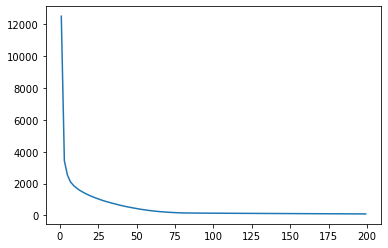

In [46]:
approx_range = range(1, 200, 2)
approx_error = [np.linalg.norm(original - k_rank_approximation(k, U, s, VT)) for k in approx_range]

plt.plot([k for k in approx_range], approx_error)
plt.show()

### Plot the compression factor k/m*n for increasing k

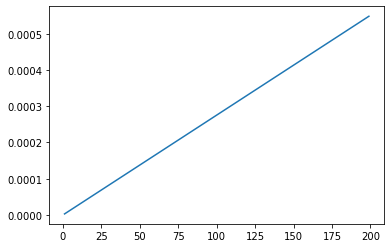

In [47]:
compression_factor = [k/(original.shape[0] * original.shape[1]) for k in approx_range]
plt.plot([k for k in approx_range], compression_factor)
plt.show()